In [ ]:
!pip install torch torchvision torchaudio
!pip install transformers


Found existing installation: torch 2.2.1
Uninstalling torch-2.2.1:
  Would remove:
    /usr/local/bin/convert-caffe2-to-onnx
    /usr/local/bin/convert-onnx-to-caffe2
    /usr/local/bin/torchrun
    /usr/local/lib/python3.10/dist-packages/functorch/*
    /usr/local/lib/python3.10/dist-packages/torch-2.2.1.dist-info/*
    /usr/local/lib/python3.10/dist-packages/torch/*
    /usr/local/lib/python3.10/dist-packages/torchgen/*
Proceed (Y/n)? Y
  Successfully uninstalled torch-2.2.1
Y
  Using cached torch-2.2.2-cp310-cp310-manylinux1_x86_64.whl (755.5 MB)
  Using cached torch-2.2.1-cp310-cp310-manylinux1_x86_64.whl (755.5 MB)
  Using cached transformers-4.40.0-py3-none-any.whl (9.0 MB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 33.0 MB/s eta 0:00:00
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.15.2
    Uninstalling tokenizers-0.15.2:
      Successfully uninstalled tokenizers-0.15.2


In [ ]:
pip install optuna


In [ ]:
from google.colab import drive
import pandas as pd
import numpy as np
import torch
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
import optuna
from joblib import dump
import warnings
import re

# Ignore warnings
warnings.filterwarnings('ignore')

# Define global variables for X_train, y_train, X_val, and y_val
X_train, y_train, X_val, y_val = None, None, None, None

def load_data():
    # Mount Google Drive
    drive.mount('/content/drive')

    # Load the DataFrames
    folder_path = '/content/drive/My Drive/Hs/'

    # Load the datasets
    admissions = pd.read_csv(folder_path + 'admissions.csv')
    patients = pd.read_csv(folder_path + 'patients.csv')
    icustays = pd.read_csv(folder_path + 'icustays.csv')
    diagnoses_icd = pd.read_csv(folder_path + 'diagnoses_icd.csv')
    d_icd_diagnoses = pd.read_csv(folder_path + 'd_icd_diagnoses.csv')

    # Merge datasets based on common columns using inner join
    merged_data = pd.merge(admissions, patients, on='subject_id', how='inner')
    merged_data = pd.merge(merged_data, icustays, on=['subject_id', 'hadm_id'], how='inner')
    merged_data = pd.merge(merged_data, diagnoses_icd, on=['subject_id', 'hadm_id'], how='inner')
    d_icd_diagnoses['long_title'] = d_icd_diagnoses['long_title'].apply(preprocess_text)
    merged_data = pd.merge(merged_data, d_icd_diagnoses, on=['icd_code', 'icd_version'], how='inner')
    merged_data.rename(columns={'hospital_expire_flag': 'label', 'long_title': 'text'}, inplace=True)

    # Feature Engineering
    categories = ['Short', 'Medium', 'Long']
    short_threshold = 2.0
    medium_threshold = 5.0

    # Categorize Length of Stay (LOS)
    merged_data['LOS_Category'] = pd.cut(merged_data['los'], bins=[0, short_threshold, medium_threshold, float('inf')],
                                         labels=categories, right=False)

    # Drop unnecessary columns
    columns_to_drop = ['deathtime', 'admit_provider_id', 'dod', 'los', 'language', 'seq_num', 'insurance']
    merged_data = merged_data.drop(columns=columns_to_drop)

    # Handling missing values
    merged_data.dropna(inplace=True)

    return merged_data

def preprocess_text(text):
    # Remove punctuation using regex
    text = re.sub(r'[^\w\s]', '', text)
    return text

# Define objective function for Optuna
def objective(trial):
    # Define parameters to search
    lr = trial.suggest_loguniform('lr', 1e-6, 1e-4)
    epochs = trial.suggest_int('epochs', 3, 5)
    batch_size = trial.suggest_categorical('batch_size', [16, 32, 64])

    # Initialize BERT tokenizer and model
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3)  # Adjust for 3 classes

    # Define optimizer
    optimizer = AdamW(model.parameters(), lr=lr)

    # Split data into train, validation, and test sets
    X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.111, random_state=42)  # 80% train, 10% validation, 10% test

    # Tokenize input data
    train_encodings = tokenizer(X_train["text"].tolist(), padding=True, truncation=True, return_tensors='pt')
    val_encodings = tokenizer(X_val["text"].tolist(), padding=True, truncation=True, return_tensors='pt')

    # Convert labels to tensors
    train_labels = torch.tensor(y_train.tolist())
    val_labels = torch.tensor(y_val.tolist())

    # Train the model
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()

        # Forward pass
        train_outputs = model(**train_encodings, labels=train_labels)
        train_loss = train_outputs.loss

        # Backward pass
        train_loss.backward()
        optimizer.step()

        # Evaluation
        model.eval()
        with torch.no_grad():
            val_outputs = model(**val_encodings)
            val_predictions = val_outputs.logits.argmax(dim=1)
            val_accuracy = accuracy_score(val_labels, val_predictions)

    return val_accuracy

# Load data
merged_df = load_data()

# Split data into features (X) and target (y)
X = merged_df.drop(columns=["label"])
y = merged_df["label"]

# Run hyperparameter optimization
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

# Print best parameters and performance
print("Best parameters found: ", study.best_params)
print("Best accuracy on validation set: {:.4f}".format(study.best_value))

# Get the best hyperparameters
best_params = study.best_params

# Reinitialize the model with the best hyperparameters
best_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
best_model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3)  # Adjust for 3 classes

# Define optimizer with best learning rate
best_optimizer = AdamW(best_model.parameters(), lr=best_params['lr'])

# Train the best model
for epoch in range(best_params['epochs']):
    best_model.train()
    best_optimizer.zero_grad()

    # Forward pass
    train_encodings = best_tokenizer(X_train["text"].tolist(), padding=True, truncation=True, return_tensors='pt')
    train_labels = torch.tensor(y_train.tolist())
    train_outputs = best_model(**train_encodings, labels=train_labels)
    train_loss = train_outputs.loss

    # Backward pass
    train_loss.backward()
    best_optimizer.step()

# Save the best model
model_filename = "BERT_Model.pkl"
torch.save(best_model.state_dict(), model_filename)
print(f"Best model saved to {model_filename}")

# Evaluate the best model on the test set
test_encodings = best_tokenizer(X_test["text"].tolist(), padding=True, truncation=True, return_tensors='pt')
test_labels = torch.tensor(y_test.tolist())
best_model.eval()
with torch.no_grad():
    test_outputs = best_model(**test_encodings)
    test_predictions = test_outputs.logits.argmax(dim=1)
    print(classification_report(test_labels.numpy(), test_predictions.numpy()))


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


[I 2024-04-18 17:08:50,912] A new study created in memory with name: no-name-8a2f06e7-d2b6-4a12-8fb0-89daf99f893e
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


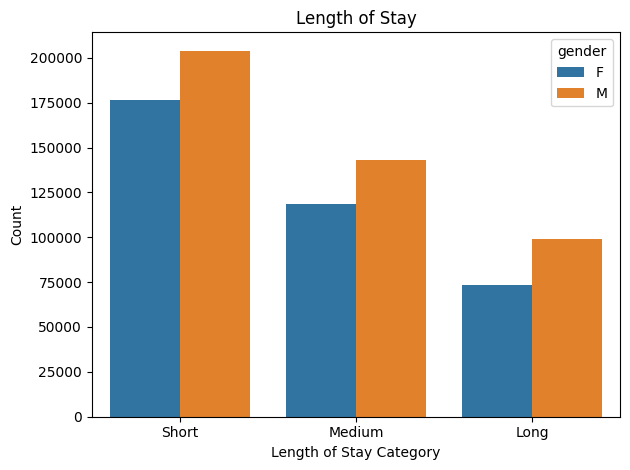

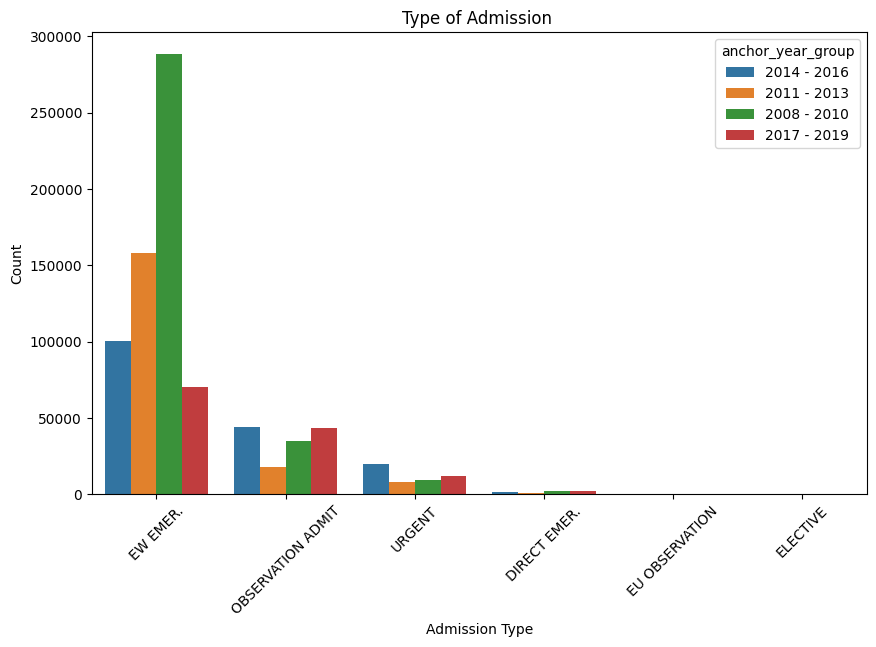

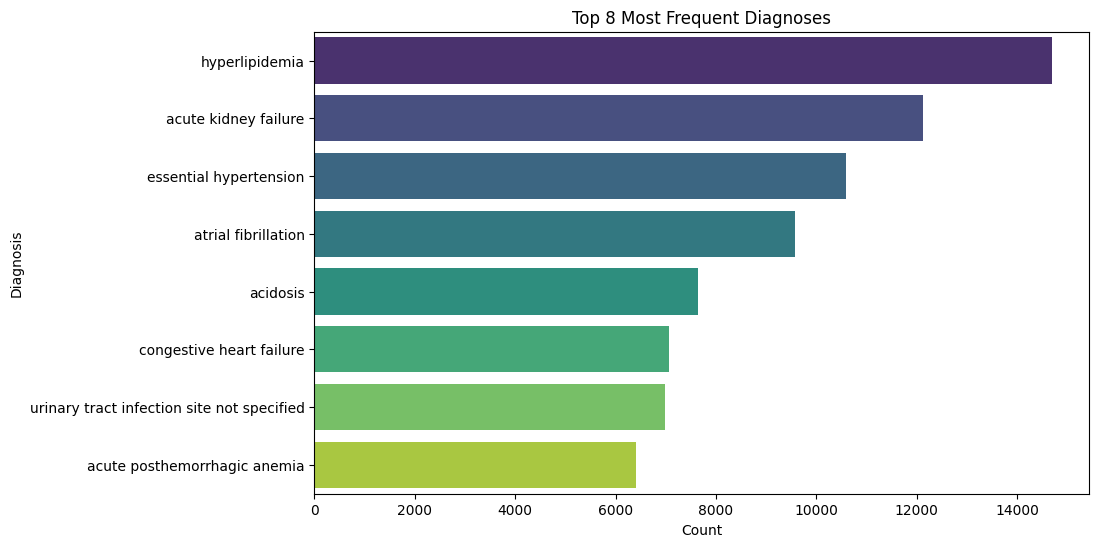

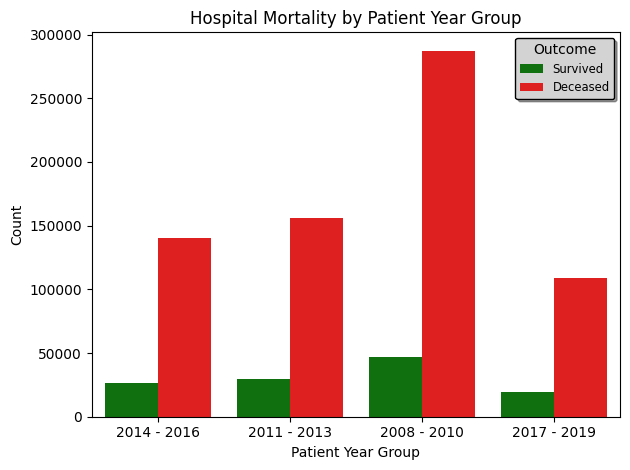

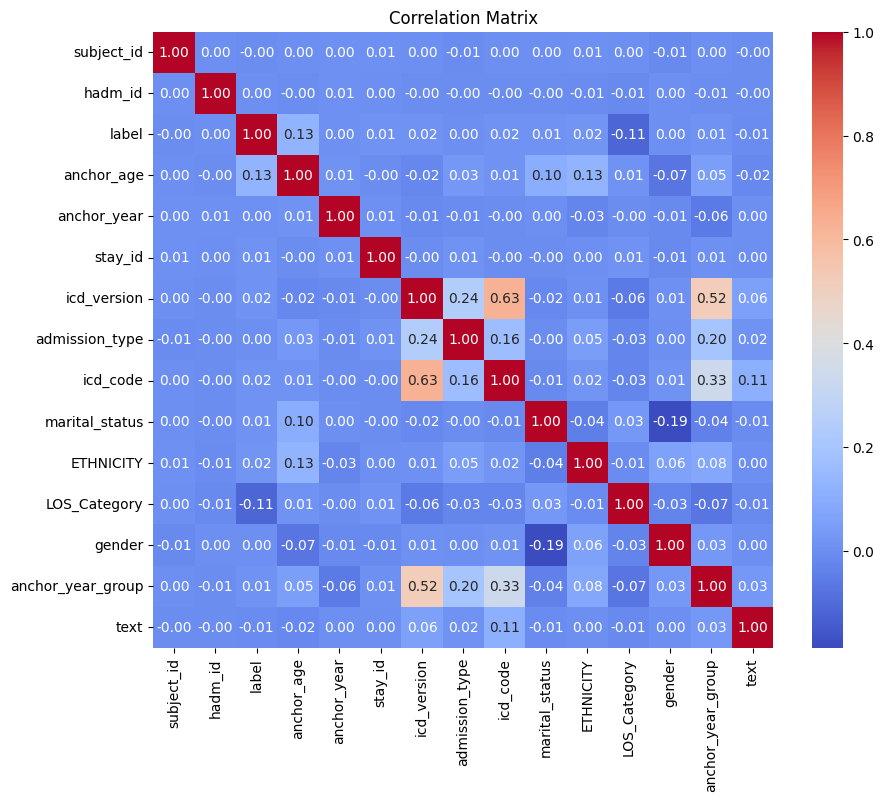

In [ ]:


# Custom BERT Classifier
class ClinicaBERTClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, model_name='emilyalsentzer/Bio_ClinicalBERT', lr=2e-5, epochs=3, batch_size=32, early_stopping=True, patience=3):
        self.model_name = model_name
        self.lr = lr
        self.epochs = epochs
        self.batch_size = batch_size
        self.early_stopping = early_stopping
        self.patience = patience

    def fit(self, X, y):
        self.model = BertForSequenceClassification.from_pretrained(self.model_name, num_labels=2)
        self.tokenizer = BertTokenizer.from_pretrained(self.model_name)
        self.optimizer = AdamW(self.model.parameters(), lr=self.lr)
        best_val_loss = float('inf')
        patience_counter = 0

        # Tokenize text data and prepare input tensors
        inputs = self.tokenizer(X["text"].tolist(), padding=True, truncation=True, return_tensors='pt', max_length=128)
        labels = torch.tensor(y.tolist())

        # Train the model
        for epoch in range(self.epochs):
            self.model.train()
            running_loss = 0.0
            for i in range(0, len(labels), self.batch_size):
                input_batch = {k: v[i:i+self.batch_size] for k, v in inputs.items()}
                label_batch = labels[i:i+self.batch_size]

                self.optimizer.zero_grad()
                outputs = self.model(**input_batch, labels=label_batch)
                loss = outputs.loss
                loss.backward()
                self.optimizer.step()

                running_loss += loss.item()

            # Early stopping
            if self.early_stopping:
                val_loss = self.evaluate_loss(X_val, y_val)
                if val_loss < best_val_loss:
                    best_val_loss = val_loss
                    patience_counter = 0
                else:
                    patience_counter += 1
                    if patience_counter >= self.patience:
                        print("Early stopping after {} epochs.".format(epoch + 1))
                        break

    def predict(self, X):
        # Tokenize text data and prepare input tensors
        inputs = self.tokenizer(X["text"].tolist(), padding=True, truncation=True, return_tensors='pt', max_length=128)

        # Evaluate the model
        self.model.eval()
        predictions = []
        with torch.no_grad():
            for i in range(0, len(inputs['input_ids']), self.batch_size):
                input_batch = {k: v[i:i+self.batch_size] for k, v in inputs.items()}
                outputs = self.model(**input_batch)
                logits = outputs.logits
                predictions.extend(logits.argmax(dim=1).cpu().tolist())
        return predictions

    def evaluate_loss(self, X, y):
        inputs = self.tokenizer(X["text"].tolist(), padding=True, truncation=True, return_tensors='pt', max_length=128)
        labels = torch.tensor(y.tolist())

        self.model.eval()
        total_loss = 0.0
        with torch.no_grad():
            for i in range(0, len(labels), self.batch_size):
                input_batch = {k: v[i:i+self.batch_size] for k, v in inputs.items()}
                label_batch = labels[i:i+self.batch_size]
                outputs = self.model(**input_batch, labels=label_batch)
                loss = outputs.loss
                total_loss += loss.item()

        return total_loss / (len(labels) / self.batch_size)

# Define objective function for Optuna
def objective(trial):
    # Define parameters to search
    lr = trial.suggest_loguniform('lr', 1e-6, 1e-4)
    epochs = trial.suggest_int('epochs', 3, 5)
    batch_size = trial.suggest_categorical('batch_size', [16, 32, 64])

    # Initialize ClinicaBERT Classifier with dynamically passed values
    clinica_bert_classifier = ClinicaBERTClassifier(
        model_name='emilyalsentzer/Bio_ClinicalBERT',
        lr=lr,
        epochs=epochs,
        batch_size=batch_size
    )

    # Train the model
    clinica_bert_classifier.fit(X_train, y_train)

    # Evaluate using validation set
    predictions = clinica_bert_classifier.predict(X_val)
    accuracy = accuracy_score(y_val, predictions)
    return accuracy




Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


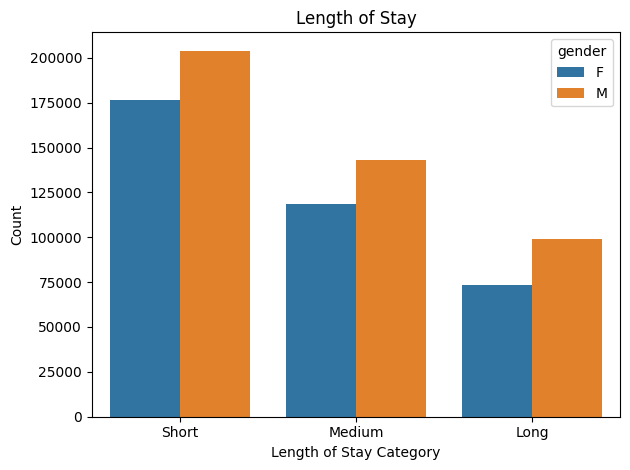

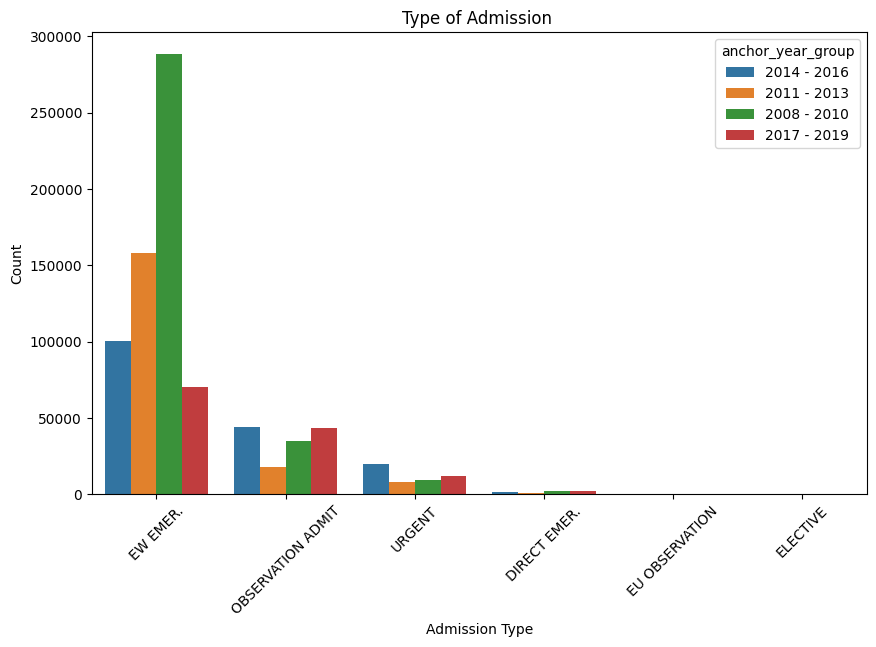

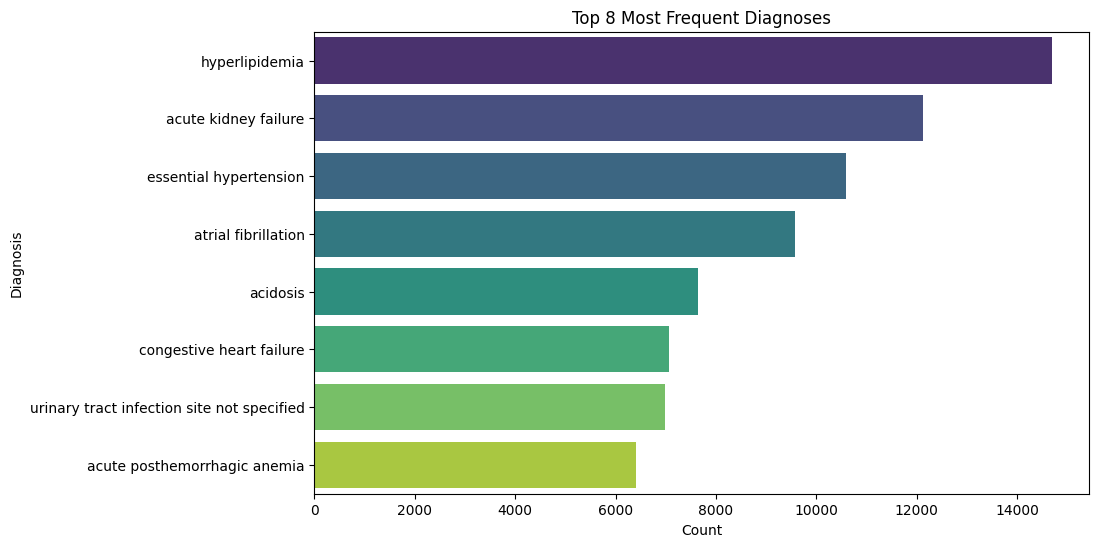

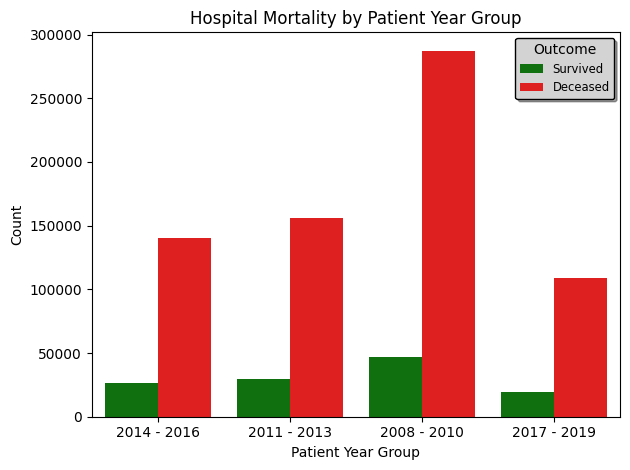

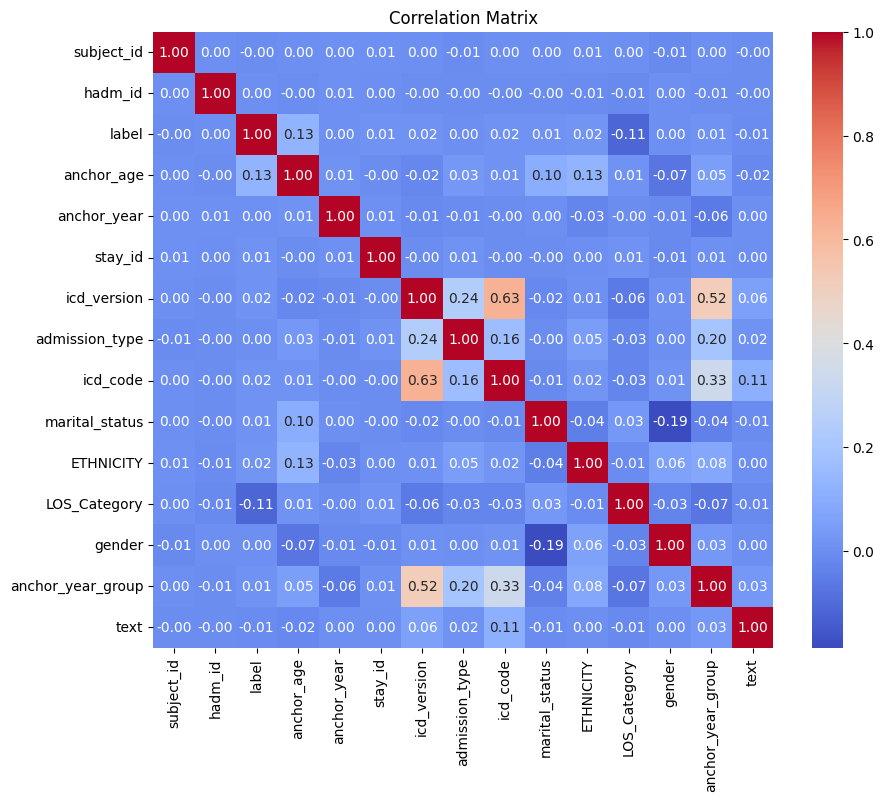

In [ ]:
import re
from google.colab import drive
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from joblib import dump
import warnings
import optuna
import torch
from transformers import BertTokenizer, BertForSequenceClassification, AdamW

# Ignore warnings
warnings.filterwarnings('ignore')

def load_data():

    # Mount Google Drive
    drive.mount('/content/drive')

    # Load the DataFrames
    folder_path = '/content/drive/My Drive/Hs/'
    admissions = pd.read_csv(folder_path + 'admissions.csv')
    patients = pd.read_csv(folder_path + 'patients.csv')
    icustays = pd.read_csv(folder_path + 'icustays.csv')
    diagnoses_icd = pd.read_csv(folder_path + 'diagnoses_icd.csv')
    d_icd_diagnoses = pd.read_csv(folder_path + 'd_icd_diagnoses.csv')

    # Merge datasets based on common columns using inner join
    merged_data = pd.merge(admissions, patients, on='subject_id', how='inner')
    merged_data = pd.merge(merged_data, icustays, on=['subject_id', 'hadm_id'], how='inner')
    merged_data = pd.merge(merged_data, diagnoses_icd, on=['subject_id', 'hadm_id'], how='inner')
    d_icd_diagnoses['long_title'] = d_icd_diagnoses['long_title'].apply(preprocess_text)
    merged_data = pd.merge(merged_data, d_icd_diagnoses, on=['icd_code', 'icd_version'], how='inner')
    merged_data.rename(columns={'hospital_expire_flag': 'label', 'long_title': 'text'}, inplace=True)

    # Feature Engineering
    categories = ['Short', 'Medium', 'Long']
    short_threshold = 2.0
    medium_threshold = 5.0

    # Categorize Length of Stay (LOS)
    merged_data['LOS_Category'] = pd.cut(merged_data['los'], bins=[0, short_threshold, medium_threshold, float('inf')],
                                         labels=categories, right=False)

    # Drop unnecessary columns
    columns_to_drop = ['deathtime', 'admit_provider_id', 'dod', 'los', 'language', 'seq_num', 'insurance']
    merged_data = merged_data.drop(columns=columns_to_drop)

    # Handling missing values
    merged_data.dropna(inplace=True)

    return merged_data


def preprocess_text(text):

    # Define words to remove (converted to lowercase)
    words_to_remove = ['and', 'or', 'unspecified', 'other']
    # Remove punctuation using regex
    text = re.sub(r'[^\w\s,]', '', text)
    # Remove commas
    text = text.replace(',', '')
    # Remove specified words (case insensitive)
    text = ' '.join(word for word in text.split() if word.lower() not in words_to_remove)
    return text


def create_data_analysis_charts(data):

    # Plot countplot
    ax = sns.countplot(data=data, x='LOS_Category', hue='gender')
    ax.set_title('Length of Stay')
    ax.set_xlabel('Length of Stay Category')
    ax.set_ylabel('Count')
    # Adjust layout and display the plot
    plt.tight_layout()
    plt.show()

    # Plot for the top 6 admission types
    plt.figure(figsize=(10, 6))
    sns.countplot(data=data, x='admission_type', order=data['admission_type'].value_counts().index[:6],  hue='anchor_year_group')
    plt.title('Type of Admission ')
    plt.xlabel('Admission Type')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.show()

    top_n = 8
    # Convert all diagnoses to lowercase to ensure case-insensitive comparison
    data['text'] = data['text'].str.lower()
    # Get the top N most frequent diagnoses after removing duplicates
    top_diagnoses = data['text'].value_counts().nlargest(top_n)
    # Plot the horizontal bar chart
    plt.figure(figsize=(10, 6))
    sns.barplot(x=top_diagnoses.values, y=top_diagnoses.index, palette='viridis')
    plt.title(f'Top {top_n} Most Frequent Diagnoses')
    plt.xlabel('Count')
    plt.ylabel('Diagnosis')
    plt.show()

    # Map original label values to custom labels
    label_mapping = {1: 'Deceased', 0: 'Survived'}
    # Set custom colors for each label
    custom_palette = {1: 'green', 0: 'red'}
    # Plot countplot
    ax = sns.countplot(data=data, x='anchor_year_group', hue='label', palette=custom_palette, hue_order=[1, 0])
    ax.set_title('Hospital Mortality by Patient Year Group')
    ax.set_xlabel('Patient Year Group')
    ax.set_ylabel('Count')
    # Set custom labels for hue variable
    legend_labels = [label_mapping[label] for label in sorted(data['label'].unique())]
    # Set custom colors for legend
    legend_colors = [custom_palette[label] for label in sorted(data['label'].unique())]
    ax.legend(title='Outcome', labels=legend_labels, loc='upper right', fontsize='small', facecolor='lightgrey', edgecolor='black', fancybox=True, shadow=True)
    # Adjust layout and display the plot
    plt.tight_layout()
    plt.show()

    # Encode categorical variables
    encoder = LabelEncoder()
    categorical_columns = ['admission_type','icd_code', 'marital_status', 'ETHNICITY', 'LOS_Category', 'gender', 'anchor_year_group','label','text']
    plt.figure(figsize=(10, 8))
    # Exclude non-numeric columns from the correlation matrix
    numeric_data = data.select_dtypes(include=[np.number])
    for col in categorical_columns:
        numeric_data[col] = encoder.fit_transform(data[col])
    sns.heatmap(numeric_data.corr(), annot=True, cmap='coolwarm', fmt=".2f")
    plt.title('Correlation Matrix')
    plt.show()


# Load data
merged_df = load_data()
# Create data analysis charts
create_data_analysis_charts(merged_df)


In [ ]:
from google.colab import drive
import pandas as pd
import numpy as np
import torch
from transformers import BertTokenizer, AdamW, BertForSequenceClassification
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, ClassifierMixin
import optuna
from joblib import dump  # Added import for dump function from joblib
import warnings

# Ignore warnings
warnings.filterwarnings('ignore')

# Function to load data
def load_data():
    # Mount Google Drive
    drive.mount('/content/drive')
    # Load the DataFrames
    folder_path = '/content/drive/My Drive/Hs/'

    # Load the datasets
    admissions = pd.read_csv(folder_path +'admissions.csv')
    patients = pd.read_csv(folder_path +'patients.csv')
    icustays = pd.read_csv(folder_path + 'icustays.csv')
    diagnoses_icd = pd.read_csv(folder_path + 'diagnoses_icd.csv')
    d_icd_diagnoses = pd.read_csv(folder_path + 'd_icd_diagnoses.csv')

    # Merge datasets based on common columns using inner join
    merged_data = pd.merge(admissions, patients, on='subject_id', how='inner')
    merged_data = pd.merge(merged_data, icustays, on=['subject_id', 'hadm_id'], how='inner')
    merged_data = pd.merge(merged_data, diagnoses_icd, on=['subject_id', 'hadm_id'], how='inner')
    merged_data = pd.merge(merged_data, d_icd_diagnoses, on=['icd_code', 'icd_version'], how='inner')
    merged_data.rename(columns={'hospital_expire_flag': 'label', 'long_title': 'text'}, inplace=True)
    merged_data.dropna(inplace=True)
    print(merged_data.isnull().sum())
    merged_data = merged_data.sample(100, random_state=42)
    return merged_data

# Custom BERT Classifier
class MedBERTClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, model_name='microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract', lr=2e-5, epochs=3, batch_size=32, early_stopping=True, patience=3):
        self.model_name = model_name
        self.lr = lr
        self.epochs = epochs
        self.batch_size = batch_size
        self.early_stopping = early_stopping
        self.patience = patience

    def fit(self, X, y):
        self.model = BertForSequenceClassification.from_pretrained(self.model_name, num_labels=2)
        self.tokenizer = BertTokenizer.from_pretrained(self.model_name)
        self.optimizer = AdamW(self.model.parameters(), lr=self.lr)
        best_val_loss = float('inf')
        patience_counter = 0

        # Tokenize text data and prepare input tensors
        inputs = self.tokenizer(X["text"].tolist(), padding=True, truncation=True, return_tensors='pt', max_length=128)
        labels = torch.tensor(y.tolist())

        # Train the model
        for epoch in range(self.epochs):
            self.model.train()
            running_loss = 0.0
            for i in range(0, len(labels), self.batch_size):
                input_batch = {k: v[i:i+self.batch_size] for k, v in inputs.items()}
                label_batch = labels[i:i+self.batch_size]

                self.optimizer.zero_grad()
                outputs = self.model(**input_batch, labels=label_batch)
                loss = outputs.loss
                loss.backward()
                self.optimizer.step()

                running_loss += loss.item()

            # Early stopping
            if self.early_stopping:
                val_loss = self.evaluate_loss(X_val, y_val)
                if val_loss < best_val_loss:
                    best_val_loss = val_loss
                    patience_counter = 0
                else:
                    patience_counter += 1
                    if patience_counter >= self.patience:
                        print("Early stopping after {} epochs.".format(epoch + 1))
                        break

    def predict(self, X):
        # Tokenize text data and prepare input tensors
        inputs = self.tokenizer(X["text"].tolist(), padding=True, truncation=True, return_tensors='pt', max_length=128)

        # Evaluate the model
        self.model.eval()
        predictions = []
        with torch.no_grad():
            for i in range(0, len(inputs['input_ids']), self.batch_size):
                input_batch = {k: v[i:i+self.batch_size] for k, v in inputs.items()}
                outputs = self.model(**input_batch)
                logits = outputs.logits
                predictions.extend(logits.argmax(dim=1).cpu().tolist())
        return predictions

    def evaluate_loss(self, X, y):
        inputs = self.tokenizer(X["text"].tolist(), padding=True, truncation=True, return_tensors='pt', max_length=128)
        labels = torch.tensor(y.tolist())

        self.model.eval()
        total_loss = 0.0
        with torch.no_grad():
            for i in range(0, len(labels), self.batch_size):
                input_batch = {k: v[i:i+self.batch_size] for k, v in inputs.items()}
                label_batch = labels[i:i+self.batch_size]
                outputs = self.model(**input_batch, labels=label_batch)
                loss = outputs.loss
                total_loss += loss.item()

        return total_loss / (len(labels) / self.batch_size)

# Define objective function for Optuna
def objective(trial):
    # Define parameters to search
    lr = trial.suggest_loguniform('lr', 1e-6, 1e-4)
    epochs = trial.suggest_int('epochs', 3, 5)
    batch_size = trial.suggest_categorical('batch_size', [16, 32, 64])

    # Initialize MedBERT Classifier with dynamically passed values
    med_bert_classifier = MedBERTClassifier(
        model_name='microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract',
        lr=lr,
        epochs=epochs,
        batch_size=batch_size
    )

    # Train the model
    med_bert_classifier.fit(X_train, y_train)

    # Evaluate using validation set
    predictions = med_bert_classifier.predict(X_val)
    accuracy = accuracy_score(y_val, predictions)
    return accuracy

# Load data
merged_df = load_data()

# Split data into train, validation, and test sets
X = merged_df.drop(columns=["label"])
y = merged_df["label"]
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.111, random_state=42)  # 80% train, 10% validation, 10% test

# Run hyperparameter optimization
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

# Print best parameters and performance
print("Best parameters found: ", study.best_params)
print("Best accuracy on validation set: {:.4f}".format(study.best_value))

# Get the best model parameters
best_params = study.best_params

# Train the best model on the entire training and validation data
best_model = MedBERTClassifier(
    model_name='microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract',
    lr=best_params['lr'],
    epochs=best_params['epochs'],
    batch_size=best_params['batch_size']
)
best_model.fit(X_train_val, y_train_val)

# Save the best model to a pkl file
model_filename = "BiomedNLP-PubMedBERT-base-uncased_Model.pkl"  # You can choose a different filename
dump(best_model, model_filename)
print(f"Best model saved to {model_filename}")

# Evaluate the best model on the test set
test_predictions = best_model.predict(X_test)
test_accuracy = accuracy_score(y_test, test_predictions)
test_precision = precision_score(y_test, test_predictions)
test_recall = recall_score(y_test, test_predictions)
test_f1 = f1_score(y_test, test_predictions)

print("Accuracy on test set: {:.4f}".format(test_accuracy))
print("Precision on test set: {:.4f}".format(test_precision))
print("Recall on test set: {:.4f}".format(test_recall))
print("F1-score on test set: {:.4f}".format(test_f1))


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


[I 2024-04-17 16:46:15,713] A new study created in memory with name: no-name-7a98fa35-3ea8-4564-a786-2c9661675bf1


subject_id            0
hadm_id               0
admittime             0
dischtime             0
deathtime             0
admission_type        0
admit_provider_id     0
admission_location    0
discharge_location    0
insurance             0
language              0
marital_status        0
ETHNICITY             0
edregtime             0
edouttime             0
label                 0
gender                0
anchor_age            0
anchor_year           0
anchor_year_group     0
dod                   0
stay_id               0
first_careunit        0
last_careunit         0
intime                0
outtime               0
los                   0
seq_num               0
icd_code              0
icd_version           0
text                  0
dtype: int64


config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/225k [00:00<?, ?B/s]

[I 2024-04-17 16:46:30,330] Trial 0 finished with value: 1.0 and parameters: {'lr': 4.5745364075126895e-05, 'epochs': 5, 'batch_size': 32}. Best is trial 0 with value: 1.0.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[I 2024-04-17 16:46:36,446] Trial 1 finished with value: 1.0 and parameters: {'lr': 1.2300497954405638e-05, 'epochs': 4, 'batch_size': 32}. Best is trial 0 with value: 1.0.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference

Best parameters found:  {'lr': 4.5745364075126895e-05, 'epochs': 5, 'batch_size': 32}
Best accuracy on validation set: 1.0000


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Best model saved to BiomedNLP-PubMedBERT-base-uncased_Model.pkl
Accuracy on test set: 1.0000
Precision on test set: 1.0000
Recall on test set: 1.0000
F1-score on test set: 1.0000


In [ ]:
from google.colab import drive
import pandas as pd
import numpy as np
import torch
from transformers import BertTokenizer, AdamW, BertForSequenceClassification
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, ClassifierMixin
import optuna
from joblib import dump  # Added import for dump function from joblib
import warnings

# Ignore warnings
warnings.filterwarnings('ignore')

# Function to load data
def load_data():
    # Mount Google Drive
    drive.mount('/content/drive')
    # Load the DataFrames
    folder_path = '/content/drive/My Drive/Hs/'

    # Load the datasets
    admissions = pd.read_csv(folder_path +'admissions.csv')
    patients = pd.read_csv(folder_path +'patients.csv')
    icustays = pd.read_csv(folder_path + 'icustays.csv')
    diagnoses_icd = pd.read_csv(folder_path + 'diagnoses_icd.csv')
    d_icd_diagnoses = pd.read_csv(folder_path + 'd_icd_diagnoses.csv')

    # Merge datasets based on common columns using inner join
    merged_data = pd.merge(admissions, patients, on='subject_id', how='inner')
    merged_data = pd.merge(merged_data, icustays, on=['subject_id', 'hadm_id'], how='inner')
    merged_data = pd.merge(merged_data, diagnoses_icd, on=['subject_id', 'hadm_id'], how='inner')
    merged_data = pd.merge(merged_data, d_icd_diagnoses, on=['icd_code', 'icd_version'], how='inner')
    merged_data.rename(columns={'hospital_expire_flag': 'label', 'long_title': 'text'}, inplace=True)
    merged_data.dropna(inplace=True)
    print(merged_data.isnull().sum())
    merged_data = merged_data.sample(100, random_state=42)
    return merged_data

# Custom BERT Classifier
class BioBERTClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, model_name='dmis-lab/biobert-v1.1', lr=2e-5, epochs=3, batch_size=32, early_stopping=True, patience=3):
        self.model_name = model_name
        self.lr = lr
        self.epochs = epochs
        self.batch_size = batch_size
        self.early_stopping = early_stopping
        self.patience = patience

    def fit(self, X, y):
        self.model = BertForSequenceClassification.from_pretrained(self.model_name, num_labels=2)
        self.tokenizer = BertTokenizer.from_pretrained(self.model_name)
        self.optimizer = AdamW(self.model.parameters(), lr=self.lr)
        best_val_loss = float('inf')
        patience_counter = 0

        # Tokenize text data and prepare input tensors
        inputs = self.tokenizer(X["text"].tolist(), padding=True, truncation=True, return_tensors='pt', max_length=128)
        labels = torch.tensor(y.tolist())

        # Train the model
        for epoch in range(self.epochs):
            self.model.train()
            running_loss = 0.0
            for i in range(0, len(labels), self.batch_size):
                input_batch = {k: v[i:i+self.batch_size] for k, v in inputs.items()}
                label_batch = labels[i:i+self.batch_size]

                self.optimizer.zero_grad()
                outputs = self.model(**input_batch, labels=label_batch)
                loss = outputs.loss
                loss.backward()
                self.optimizer.step()

                running_loss += loss.item()

            # Early stopping
            if self.early_stopping:
                val_loss = self.evaluate_loss(X_val, y_val)
                if val_loss < best_val_loss:
                    best_val_loss = val_loss
                    patience_counter = 0
                else:
                    patience_counter += 1
                    if patience_counter >= self.patience:
                        print("Early stopping after {} epochs.".format(epoch + 1))
                        break

    def predict(self, X):
        # Tokenize text data and prepare input tensors
        inputs = self.tokenizer(X["text"].tolist(), padding=True, truncation=True, return_tensors='pt', max_length=128)

        # Evaluate the model
        self.model.eval()
        predictions = []
        with torch.no_grad():
            for i in range(0, len(inputs['input_ids']), self.batch_size):
                input_batch = {k: v[i:i+self.batch_size] for k, v in inputs.items()}
                outputs = self.model(**input_batch)
                logits = outputs.logits
                predictions.extend(logits.argmax(dim=1).cpu().tolist())
        return predictions

    def evaluate_loss(self, X, y):
        inputs = self.tokenizer(X["text"].tolist(), padding=True, truncation=True, return_tensors='pt', max_length=128)
        labels = torch.tensor(y.tolist())

        self.model.eval()
        total_loss = 0.0
        with torch.no_grad():
            for i in range(0, len(labels), self.batch_size):
                input_batch = {k: v[i:i+self.batch_size] for k, v in inputs.items()}
                label_batch = labels[i:i+self.batch_size]
                outputs = self.model(**input_batch, labels=label_batch)
                loss = outputs.loss
                total_loss += loss.item()

        return total_loss / (len(labels) / self.batch_size)

# Define objective function for Optuna
def objective(trial):
    # Define parameters to search
    lr = trial.suggest_loguniform('lr', 1e-6, 1e-4)
    epochs = trial.suggest_int('epochs', 3, 5)
    batch_size = trial.suggest_categorical('batch_size', [16, 32, 64])

    # Initialize BioBERT Classifier with dynamically passed values
    bio_bert_classifier = BioBERTClassifier(
        model_name='dmis-lab/biobert-v1.1',
        lr=lr,
        epochs=epochs,
        batch_size=batch_size
    )

    # Train the model
    bio_bert_classifier.fit(X_train, y_train)

    # Evaluate using validation set
    predictions = bio_bert_classifier.predict(X_val)
    accuracy = accuracy_score(y_val, predictions)
    return accuracy

# Load data
merged_df = load_data()

# Split data into train, validation, and test sets
X = merged_df.drop(columns=["label"])
y = merged_df["label"]
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.111, random_state=42)  # 80% train, 10% validation, 10% test

# Run hyperparameter optimization
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

# Print best parameters and performance
print("Best parameters found: ", study.best_params)
print("Best accuracy on validation set: {:.4f}".format(study.best_value))

# Get the best model parameters
best_params = study.best_params

# Train the best model on the entire training and validation data
best_model = BioBERTClassifier(
    model_name='dmis-lab/biobert-v1.1',
    lr=best_params['lr'],
    epochs=best_params['epochs'],
    batch_size=best_params['batch_size']
)
best_model.fit(X_train_val, y_train_val)

# Save the best model to a pkl file
model_filename = "Biobert-base-uncased_Model.pkl"  # You can choose a different filename
dump(best_model, model_filename)
print(f"Best model saved to {model_filename}")

# Evaluate the best model on the test set
test_predictions = best_model.predict(X_test)
test_accuracy = accuracy_score(y_test, test_predictions)
test_precision = precision_score(y_test, test_predictions)
test_recall = recall_score(y_test, test_predictions)
test_f1 = f1_score(y_test, test_predictions)

print("Accuracy on test set: {:.4f}".format(test_accuracy))
print("Precision on test set: {:.4f}".format(test_precision))
print("Recall on test set: {:.4f}".format(test_recall))
print("F1-score on test set: {:.4f}".format(test_f1))


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


[I 2024-04-17 16:56:51,916] A new study created in memory with name: no-name-5f5a9196-2076-49ac-8d5d-427bef31ed1c


subject_id            0
hadm_id               0
admittime             0
dischtime             0
deathtime             0
admission_type        0
admit_provider_id     0
admission_location    0
discharge_location    0
insurance             0
language              0
marital_status        0
ETHNICITY             0
edregtime             0
edouttime             0
label                 0
gender                0
anchor_age            0
anchor_year           0
anchor_year_group     0
dod                   0
stay_id               0
first_careunit        0
last_careunit         0
intime                0
outtime               0
los                   0
seq_num               0
icd_code              0
icd_version           0
text                  0
dtype: int64


config.json:   0%|          | 0.00/462 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/433M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dmis-lab/biobert-v1.1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

[I 2024-04-17 16:57:03,747] Trial 0 finished with value: 1.0 and parameters: {'lr': 9.001975304796256e-06, 'epochs': 5, 'batch_size': 16}. Best is trial 0 with value: 1.0.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dmis-lab/biobert-v1.1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[I 2024-04-17 16:57:07,770] Trial 1 finished with value: 1.0 and parameters: {'lr': 1.2344384627259756e-06, 'epochs': 3, 'batch_size': 64}. Best is trial 0 with value: 1.0.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dmis-lab/biobert-v1.1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[I 2024-04-17 16:57:13,572] Trial 2 finished with value: 1.0 

Best parameters found:  {'lr': 9.001975304796256e-06, 'epochs': 5, 'batch_size': 16}
Best accuracy on validation set: 1.0000


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dmis-lab/biobert-v1.1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Best model saved to Biobert-base-uncased_Model.pkl
Accuracy on test set: 1.0000
Precision on test set: 1.0000
Recall on test set: 1.0000
F1-score on test set: 1.0000
